# Machine Intelligence 2 
## Exercise Sheet 3: Kernel Principal Component Analysis
### Coding Solutions

### H2.1

In [1]:
# import libraries that we are going to need
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.rcParams.update({
    "text.usetex": False,  # Enable LaTeX rendering
    "font.family": "serif",  # Use serif fonts
    "font.serif": ["Times New Roman"],  # Match LaTeX default
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}) # just some global font settings for matplotlib (not necessary)



(a) Create a dataset of 2-dimensional data points x(α) = (x(α)1 ,x(α)2 ), α = 1,...,90. The points represent iid samples from 3 different distributions with uncorrelated, normally distributed (SD=0.1) coordinate values. Draw 30 samples from each distribution. The only difference between the distributions is their mean:

• The first 30 samples (i.e. α= 1,...,30) should be centered on ⟨x(α)⟩1 = (−0.5,−0.2)

• The second subset (i.e. α= 31,...,60) should have ⟨x(α)⟩2 = ( 0,0.6)

• The third subset (i.e. α= 61,...,90) should have ⟨x(α)⟩3 = (0.5, 0 )

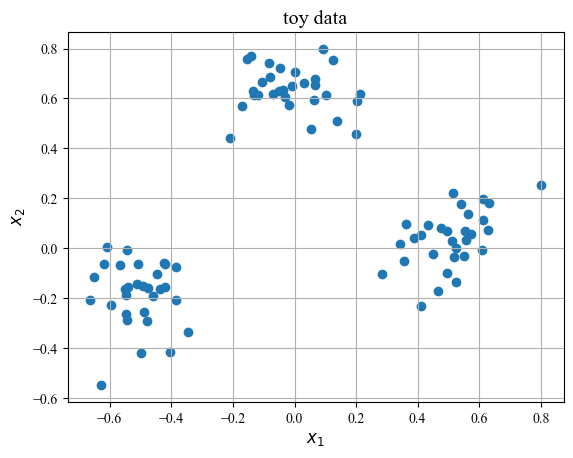

In [2]:
# create our toy dataset

# define our covariance matrix for all three distributions
std = 0.1
cov = (std ** 2) * np.eye(2, 2)

# define means of our three distributions
mu1 = np.array([-0.5, -0.2])
mu2 = np.array([0.0, 0.6])
mu3 = np.array([0.5, 0.0])

# define data matrix
n = 30  # number of data per cluster
c = 3  # number of clusters
d = 2  # dimension of data

data = np.zeros((n * c, d))  # data matrix 

# sample data into data matrix 
data[0:30, :] = np.random.multivariate_normal(mu1, cov, size=n)
data[30:60, :] = np.random.multivariate_normal(mu2, cov, size=n)
data[60:90, :] = np.random.multivariate_normal(mu3, cov, size=n)

# plot data
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('toy data')
ax.grid()
plt.show()

(b) Apply Kernel PCA using an RBF kernel with a suitable value for the width $\sigma$ of the kernel and calculate the coefficients for the representation of the eigenvectors (PCs) in the space spanned by the transformed data points.

In [3]:
# now we will define a kernel PCA class implementing all relevant functions for calculations in b) and c), 
# in the cell after this one we wil go through the steps of calculating the kernel PCA Evec representation in transformed data space using our class

class K_PCA():

    def __init__(self, data):
        '''
        init function for kernel PCA class
        
        Parameters:
        ----------
        data: array-like
            data matrix of dim (p,d)    
            
        Returns:
        -------
        return_value : 
            returns kernel PCA class instance
        '''

        self.data = data
        self.p = data.shape[0]  # number of datapoints

    def rbf_kernel(self, x, x_, sigma):
        '''
        rbf function, taking two arrays, returning kernel matrix of arrays

        Parameters:
        ----------
        x: array-like
            array of dim (p,d)
        x_: array-like
            array of dim (p_,d)
            
    
        Returns:
        -------
        return value : array_like
            returns kernel matrix of dim (p,p_)
            
        Note: d needs to be the same for x,x_
        '''
        self.sigma = sigma
        diff = x[:, np.newaxis, :] - x_[np.newaxis, :,
                                     :]  # use broadcasting to compute the subtraction efficiently, get shape (p,p_,d)
        norm_2 = np.linalg.norm(diff, axis=2) ** 2  # norm needs to be squared, get shape (p,p_)
        self.K = np.exp(-norm_2 / (2 * sigma ** 2))

        return self.K

    def center(self, K):
        '''
        center kernel matrix in feature space (ie in transformed space of data points)

        Parameters:
        ----------
        K: array-like
            kernel matrix of dim (p,p_)
            
    
        Returns:
        -------
        return_value : array_like
            returns centered (in feature space) kernel matrix of dim (p,p_)
        '''
        self.K_c = K - np.mean(K, axis=0, keepdims=True) - np.mean(K, axis=1, keepdims=True) + np.mean(K)

        return self.K_c

    def eprob(self, M):
        '''
        solve eigenvalue problem of a matrix
        
        Parameters:
        ----------
        M: array-like
            centered matrix of dim (n,n)
            
            
        Returns:
        -------
        return_value : array_like
            returns eigenvalues and eigenvectors of the matrix M
        '''
        evals, PCs = np.linalg.eigh(M)  # compute Evals and PCs
        sorter = np.argsort(evals)[::-1]
        evals = evals[sorter]
        PCs = PCs[:, sorter]  # sort PCs in descending order of evals

        return evals, PCs

    def fit(self, sigma):
        '''
        fit kernel PCA, ie compute kernel matrix, center it and solve eigenvalue problem

        Parameters:
        ----------
        sigma: float
            width of the kernel
            
    
        Returns:
        -------
        return_value : array_like
            returns eigenvalues and normalized (in original space) eigenvectors (shape: (p,p) as in basis of feature space) of the centered kernel matrix
        '''
        # compute kernel matrix
        K = self.rbf_kernel(self.data, self.data, sigma)
        # center kernel matrix and divide by p
        K_c = self.center(K)
        K_c = K_c / self.p

        # solve eigenvalue problem
        evals, PCs = self.eprob(K_c)
        # normalize eigenvectors (in original space)
        PCs = PCs / np.sqrt(self.p * evals.reshape(1,
                                                   -1))  #should broadcast evals to shape (1,p) to divide each column of PCs by the corresponding eigenvalue

        return evals, PCs

    def project_n_pcs(self, PCs, X, n_pcs):
        '''
        project data points from data matrix X onto n PCs in feature space and return projection coordinates
        
        Parameters:
        ----------
        PCs: array-like
            eigenvectors of the kernel matrix of dim (p,p)
        X: array-like
            data matrix of dim (n,d), d needs to be same as before
        n_pcs: int
            number of PCs to project onto
            
        Returns:
        -------
        return_value : array_like
            returns projection coordinates of dim (n,n_pcs)
        '''
        # compute kernel matrix of X with respect to the PCs
        KX = self.rbf_kernel(self.data, X, self.sigma)  # shape: (p,n)

        # project data points onto PCs (normalized!) in feature space
        KX_c = KX - np.mean(self.K, axis=1, keepdims=True) - np.mean(KX, axis=0, keepdims=True) + np.mean(
            self.K)  # centered kernel matrix of original data x data vector X (shape: (p,n))
        proj = (PCs[:, :n_pcs].T @ KX_c).T  # shape: (n,n_pcs) from (p,n_pcs).T@(p,n) transposed

        return proj





(c) Visualize the first 8 PCs in the original 2-dimensional input space in the following way:

(i) Use equally spaced “test” gridpoints (in a rectangle [a,b]×[c,d] ⊂R2 which contains all training samples from (a) above).

(ii) Project each test point onto the first 8 eigenvectors in feature space.

(iii) Visualize the projections of the test points using contour lines in the original 2-dimensional input space. The contours should indicate points that yield the same projection onto the respective PC. You may also use a heat map or pseudo color plot (e.g. pcolor) to distinguish the different regions.

(iv) Add the 90 training points in the same plot (e.g. using small gray circles).

In [4]:
# now we will calulate the coefficients for the representation of the eigenvectors (PCs) in the space spanned by the transformed data points
# create instance of K_PCA class
kpca = K_PCA(data)
# fit kernel PCA
sigma = 0.1  # choose same sigma as we used for our toy dataset
evals, PCs = kpca.fit(sigma)

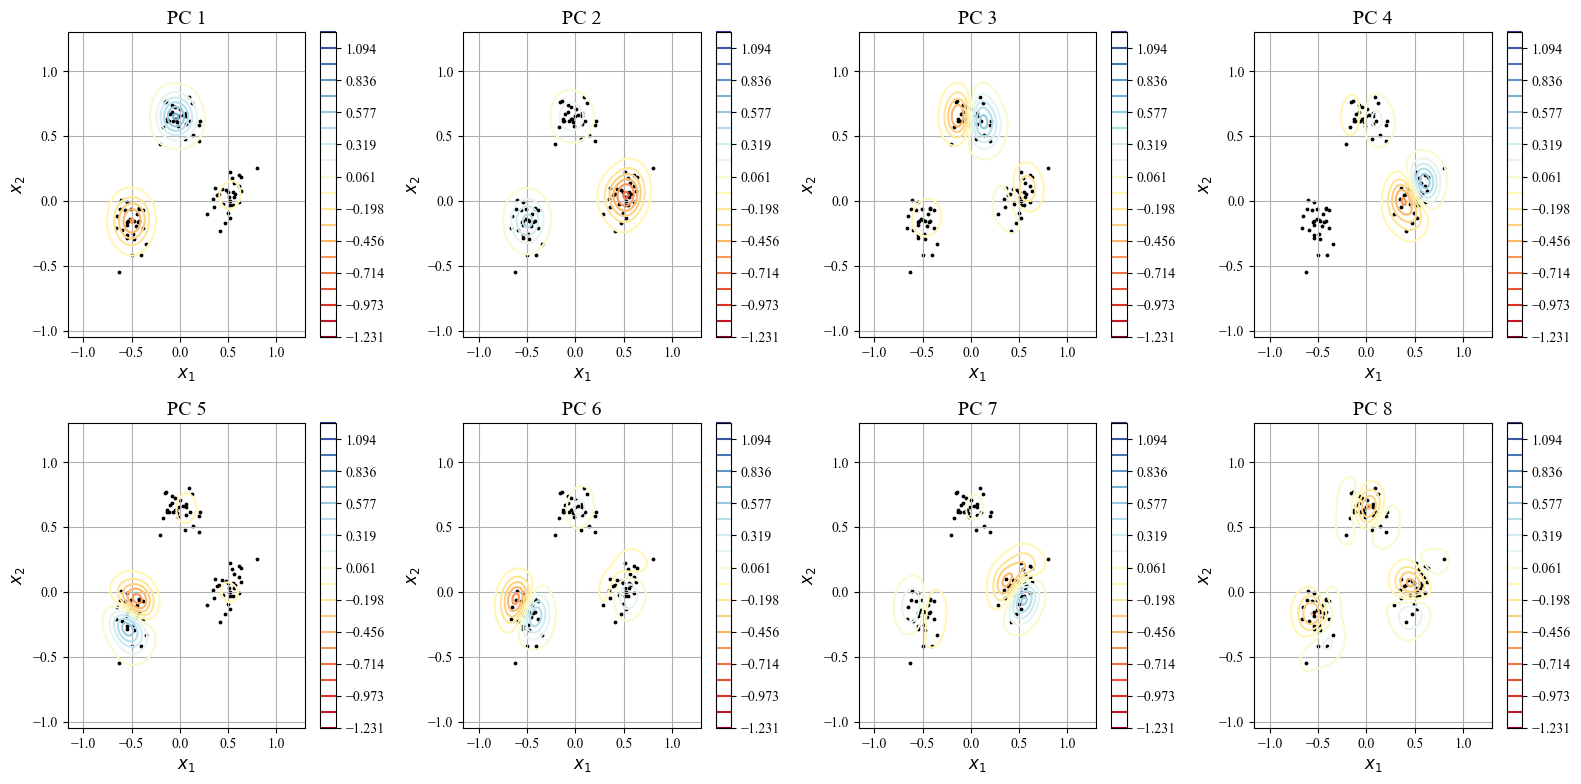

In [5]:
# we create a rectangular grid of test points in the range of the data
# define grid range, using our toy dataset as range
x_min = np.min(data[:, 0]) - 0.5
x_max = np.max(data[:, 0]) + 0.5
y_min = np.min(data[:, 1]) - 0.5
y_max = np.max(data[:, 1]) + 0.5
# define grid points
x_grid = np.linspace(x_min, x_max, 100)
y_grid = np.linspace(y_min, y_max, 100)
# create meshgrid
X, Y = np.meshgrid(x_grid, y_grid)
# flatten grid points
X_flat = X.flatten()
Y_flat = Y.flatten()
# create test data matrix
test_data = np.vstack((X_flat, Y_flat)).T  # shape: (n_test_points,2)

# now we use our above kpca class instance to project the test points onto the first 8 PCs
n_pcs = 8
proj_test = kpca.project_n_pcs(PCs, test_data, n_pcs)  # shape: (n_test_points,n_pcs)

# plot the original data and a contourplot for each projection on a PC
# create figure and axes
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()  # flatten axes array for easier indexing
# choose a color map
cmap = plt.get_cmap('RdYlBu')
# create levels for contour lines
levels = np.linspace(proj_test.min() - 0.5, proj_test.max() + 0.5, 20)
# loop over PCs
for i in range(n_pcs):
    # reshape projection of test points to grid shape for plotting with plt.contour
    proj_test_i = proj_test[:, i].reshape(X.shape)
    # plot contour lines
    cs = axs[i].contour(X, Y, proj_test_i, cmap=cmap, levels=levels)
    axs[i].scatter(data[:, 0], data[:, 1], c='black', s=3)  # plot data points
    axs[i].set_title(f'PC {i + 1}')
    axs[i].set_xlabel('$x_1$')
    axs[i].set_ylabel('$x_2$')
    fig.colorbar(cs, ax=axs[i])  # add color bar
    axs[i].grid()
# adjust layout
fig.tight_layout()
plt.show()
